# 4.手写大语言模型GPT2(模块化版本)

### 4.0 安装所需依赖，定义模型超参数

#### **1.所需依赖。**

pytorch(基本库)<br/>
tiktoken(ChatGPT研发的文字转数字)<br/>
dataclasses(自动生成类的初始化方法)

#### **2.模型超参数。**

In [18]:
# 使用 @dataclass 装饰器后，你不需要手动编写类的初始化方法。它会根据类中的字段自动生成构造函数，让你轻松地创建对象。
from dataclasses import dataclass
@dataclass
class GPTConfig:
    block_size: int = 1024 # 最大序列长度，即模型可以处理的输入文本的最大标记数
    vocab_size: int = 50257 # 词汇表的大小。GPT-2 的词汇表是基于 BPE（字节对编码）方法构建的，共包含 50,000 个 BPE 合并单元，加上 256 个字节标记，以及 1 个特殊的 <|endoftext|> 结束标记。
    n_layer: int = 12 # GPT 模型中的层数，通常指的是 Transformer 块的数量。
   
    n_head: int = 12 # 每个自注意力层中的注意力头的数量
    n_embd: int = 768 #嵌入维度，也即每个输入标记映射到的向量表示的维度。

### 4.1 定义模型

#### **1.定义GPT模型**

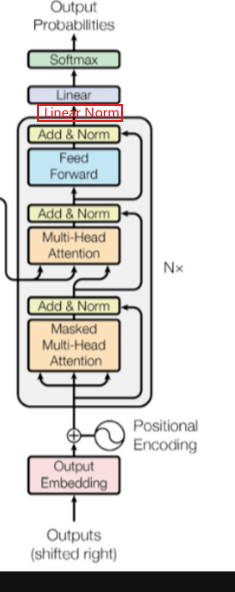

In [19]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import math
import inspect
# 评分
from hellaswag import render_example, iterate_examples

In [20]:
class CausalSelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()        
        # 断言 (assert): 确保嵌入维度 n_embd 可以被头数 n_head 整除，以便将嵌入向量拆分给不同的注意力头。
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        # 这是一个线性变换层，用于将输入的嵌入维度 n_embd 投影到 3 倍大小（即查询 q，键 k 和值 v 的拼接）。具体来说，对于每个输入 token，会计算出它的查询、键和值向量。
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)
        # 输出投影层，用于将多个注意力头的输出重新投影回原来的嵌入维度 n_embd。
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        # 分别存储注意力头的数量和嵌入维度，以便在前向传播过程中使用。
        self.n_head = config.n_head
        self.n_embd = config.n_embd

    def forward(self, x):
        # 获取输入张量 x 的维度：B 是批次大小，T 是序列长度，C 是嵌入维度（即 n_embd）。
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)
        # qkv = self.c_attn(x) 通过线性变换计算出查询 q、键 k 和值 v，并将其拆分为 3 个张量。
        qkv = self.c_attn(x)
        # q, k, v = qkv.split(self.n_embd, dim=2) 依次将 qkv 张量分割为三部分，每个部分的维度是 n_embd。
        q, k, v = qkv.split(self.n_embd, dim=2)
        # 将它们重塑为适合并行多头计算的形式，每个张量的形状变为 (B, nh, T, hs)，其中 nh 是注意力头数，hs 是每个头的维度大小。
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        
        # ----------------  被scaled_dot_product_attention 替代，因为这个函数被优化过速度更快
        # # attention (materializes the large (T,T) matrix for all the queries and keys)
        # #  计算查询和键的点积，并通过 1/sqrt(hs) 进行缩放，这是一种标准化技巧，防止点积值过大导致梯度消失。
        # att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        # # 应用因果遮罩，确保每个 token 只能关注它之前的 token（即遮罩掉未来位置的权重）。
        # att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
        # # 使用 softmax 函数计算每个位置的注意力权重。
        # att = F.softmax(att, dim=-1)
        # # 使用注意力权重矩阵乘以值向量 v，得到注意力输出，形状为 (B, nh, T, hs)。
        # y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        # #  将注意力头的输出重新整合为形状为 (B, T, C) 的张量。
        # ---------------- 
        # 替代上面的功能
        y = F.scaled_dot_product_attention(q, k, v, is_causal=True) # flash attention
        
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side
        # output projection
        # 对注意力输出进行线性变换，映射回原始的嵌入维度。
        y = self.c_proj(y)
        return y


In [21]:
# 这段代码定义了一个 MLP 类，表示 GPT 模型中每个 Transformer 块中的**前馈神经网络（MLP）**部分。
# 这个类继承自 nn.Module，由两层线性变换（全连接层）和一个 GELU 激活函数组成。

# MLP 的结构：两层全连接网络 + GELU 激活函数。输入的维度首先扩展 4 倍，然后再缩回到原来的维度。
# 作用：MLP 在 Transformer 中的作用是对每个 token 的表示进行进一步的非线性变换，从而增强模型的表达能力。
class MLP(nn.Module):

    def __init__(self, config):
        super().__init__()
        # 这是第一个全连接层，将输入的嵌入维度从 config.n_embd 扩展到 4 * config.n_embd。
        # 这种扩展在 Transformer 中很常见，它增加了模型的表示能力。
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd)
        # GELU（Gaussian Error Linear Unit）是一个激活函数，它的效果类似于 ReLU，但通常在自然语言处理任务中表现更好。
        # 这里使用了 approximate='tanh'，这是 GELU 的一种快速近似计算形式，基于 tanh 函数。
        self.gelu    = nn.GELU(approximate='tanh')
        # 第二个全连接层，将维度从 4 * config.n_embd 投影回原来的嵌入维度 config.n_embd，与模型的其他部分保持一致。
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd)

    def forward(self, x):
        # 输入首先通过第一个全连接层，将维度扩展到 4 * config.n_embd。
        x = self.c_fc(x)
        # 经过 GELU 激活函数的非线性处理，增加模型的表达能力。
        x = self.gelu(x)
        # 最后通过第二个全连接层，将维度缩回到 config.n_embd。
        x = self.c_proj(x)
        return x

In [22]:

# 这段代码定义了 Block 类，它继承自 nn.Module，表示 GPT 模型中的一个 Transformer 块。
# 每个块由层归一化、自注意力机制和前馈神经网络（MLP）组成。
class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        # 这是第一个层归一化层，用于在自注意力层之前对输入进行归一化。
        self.ln_1 = nn.LayerNorm(config.n_embd)
        # 这是自定义的因果自注意力机制（CausalSelfAttention），它实现了 GPT 模型中的自注意力功能。
        # 因果自注意力（Causal Self-Attention）保证了每个 token 只能关注到前面的 token（不能看到未来的 token），这是 GPT 模型中的一个核心机制。
        self.attn = CausalSelfAttention(config)
        # 这是第二个层归一化层，在前馈神经网络（MLP）之前使用。
        #n_embd 嵌入维度，也即每个输入标记映射到的向量表示的维度。
        self.ln_2 = nn.LayerNorm(config.n_embd)
        # 这是前馈神经网络/多层感知机（MLP），通常由一个线性变换层、激活函数（如 GELU）和另一个线性层组成。
        # 前馈神经网络的作用是在每个位置上对 token 的向量表示进行非线性变换。
        self.mlp = MLP(config)

    def forward(self, x):
        # 输入首先通过 ln_1 进行归一化，然后传递给因果自注意力层。
        # 自注意力层的输出与输入进行残差连接（即将原始输入与输出相加），这是 Transformer 的重要特性，能够缓解梯度消失问题并增强模型的稳定性。
        x = x + self.attn(self.ln_1(x))
        
        # 输出结果再次通过 ln_2 归一化，然后传递给多层感知机（MLP）。
        # 再次通过残差连接，将原始输入和 MLP 的输出相加。        
        x = x + self.mlp(self.ln_2(x))
        return x

In [23]:
class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            # wte = nn.Embedding(config.vocab_size, config.n_embd)：词嵌入层，用于将每个输入 token 映射为一个高维向量。
            # vocab_size 决定了词汇表的大小，n_embd 是嵌入向量的维度。
            #就是图中的OutPut
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            # wpe = nn.Embedding(config.block_size, config.n_embd)：位置嵌入层，用于表示序列中每个 token 的位置，以此向模型提供位置信息。
            # block_size 是序列的最大长度。n_embd 是嵌入向量的维度。
            #就是图中的位置向量
            wpe = nn.Embedding(config.block_size, config.n_embd),
            # h = nn.ModuleList([Block(config) for _ in range(config.n_layer)])：这是一组Transformer 块，每个块会包含自注意力机制和前馈网络的子层。
            # n_layer 决定了总的 Transformer 块数量，Block 类应该定义了 GPT 模型中的每个 Transformer 层的具体结构。
            #就是途中灰色的框的部分
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            # Layer Normalization（层归一化），应用在 Transformer 块的最后，用于对每个批次的输入数据进行归一化，帮助稳定训练过程。
            #这是我们GPT2新加的LayerNorm，图中的红色
            ln_f = nn.LayerNorm(config.n_embd),
        ))
        # 图中末尾linear的部分
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        
        # self.transformer.wte.weight：这是 Transformer 模型的词嵌入层（word embedding layer）的权重。wte 代表 "word token embeddings"。

        # self.lm_head.weight：这是语言模型头部（language model head）的权重。通常，语言模型头部用于生成最终的预测输出，其权重矩阵常常与词嵌入层的权重矩阵相同，以实现词汇表映射。
        
        # 权重共享：在某些模型架构中，词嵌入层和输出层使用相同的权重矩阵。这种做法可以节省内存并使得模型在训练和推理时的表现更加一致。通过共享权重，模型可以将词嵌入直接映射到输出空间。
        self.transformer.wte.weight = self.lm_head.weight
        # 初始化模型的参数
        # 调用 self.apply 方法，将 `_init_weights` 方法应用到模型中的所有子模块
        self.apply(self._init_weights)

    def _init_weights(self, module):
        # 自定义权重初始化方法
        if isinstance(module, nn.Linear):
            # 如果模块是全连接层（nn.Linear）
            # 1/sqrt(_d_model) =>0.02
            std = 0.02  # 默认标准差
            if hasattr(module, 'NANOGPT_SCALE_INIT'):
                # 如果模块有 'NANOGPT_SCALE_INIT' 属性，调整标准差
                std *= (2 * self.config.n_layer) ** -0.5
            # 使用正态分布初始化权重，均值为 0，标准差为 std
            torch.nn.init.normal_(module.weight, mean=0.0, std=std)
            if module.bias is not None:
                # 如果有偏置项，使用零初始化
                torch.nn.init.zeros_(module.bias)

        elif isinstance(module, nn.Embedding):
            # 如果模块是嵌入层（nn.Embedding）
            # 使用正态分布初始化权重，均值为 0，标准差为 0.02
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
    
    
    # 一个标准的 Transformer 模型的前向传播实现，用于 GPT 模型的文本生成任务。它处理输入的 token 和位置嵌入，然后通过 Transformer 块进行处理，最后输出 logits。
    def forward(self, idx,targets=None):
        # idx is of shape (B, T)
        # 输入: idx 是一个形状为 (B, T) 的张量，表示批量大小为 B，序列长度为 T 的 token 索引。
        B, T = idx.size()
        # 断言: 确保序列长度 T 不超过模型配置中的 block_size。
        assert T <= self.config.block_size, f"Cannot forward sequence of length {T}, block size is only {self.config.block_size}"
       
        # 位置嵌入:
        # pos 是一个从 0 到 T-1 的张量，表示位置索引。
        # pos_emb 是根据这些位置索引从位置嵌入层中获取的嵌入，形状为 (T, n_embd)。
        pos = torch.arange(0, T, dtype=torch.long, device=idx.device) # shape (T)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (T, n_embd)
        
        #         token 嵌入:
        # tok_emb 是从 token 嵌入层中获取的 token 嵌入，形状为 (B, T, n_embd)。
        tok_emb = self.transformer.wte(idx) # token embeddings of shape (B, T, n_embd)
        # 合成输入:
        # 将 token 嵌入和位置嵌入相加，得到最终的输入张量 x，形状为 (B, T, n_embd)。
        x = tok_emb + pos_emb
        # forward the blocks of the transformer
        #         Transformer 块:
        # 遍历所有的 Transformer 块（self.transformer.h 是一个包含所有 Transformer 块的 ModuleList），将 x 逐块传递，通过每个 Transformer 块进行计算。
        for block in self.transformer.h:
            x = block(x)
        # forward the final layernorm and the classifier
        # x 经过最终的层归一化 self.transformer.ln_f(x)。
        x = self.transformer.ln_f(x)
        #         分类器:
        # x 通过线性分类器 self.lm_head，得到形状为 (B, T, vocab_size) 的 logits。这些 logits 可以用来计算每个位置的词汇分布概率。
        logits = self.lm_head(x) # (B, T, vocab_size)
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
        return logits,loss
    
    # 加载预训练模型权重: 从 Hugging Face 的 transformers 库加载 GPT-2 预训练模型的权重。
    # 转换权重格式: 将 Hugging Face 模型的权重格式转换为自定义 GPT 模型的格式。
    # 返回模型: 返回初始化并加载了预训练权重的 GPT 模型实例。
    @classmethod
    def from_pretrained(cls, model_type):
        """Loads pretrained GPT-2 model weights from huggingface"""
        # 确保提供的 model_type 是有效的 GPT-2 模型类型。
        assert model_type in {'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'}
        
        # 切换huggingface镜像源
        import os
        os.environ['HF_ENDPOINT'] = 'https://hf-mirror.com'
        from transformers import GPT2LMHeadModel
        print("loading weights from pretrained gpt: %s" % model_type)
        
        # 2. 设置模型配置
        # n_layer, n_head and n_embd are determined from model_type
        config_args = {
            'gpt2':         dict(n_layer=12, n_head=12, n_embd=768),  # 124M params
            'gpt2-medium':  dict(n_layer=24, n_head=16, n_embd=1024), # 350M params
            'gpt2-large':   dict(n_layer=36, n_head=20, n_embd=1280), # 774M params
            'gpt2-xl':      dict(n_layer=48, n_head=25, n_embd=1600), # 1558M params
        }[model_type]
        # 根据 model_type 设定 GPT 模型的层数、头数和嵌入维度。
        config_args['vocab_size'] = 50257 # always 50257 for GPT model checkpoints
        config_args['block_size'] = 1024 # always 1024 for GPT model checkpoints
        # create a from-scratch initialized minGPT model
        # GPT-2 模型的词汇表大小和块大小是固定的。
        config = GPTConfig(**config_args)
        model = GPT(config)
        
        
        sd = model.state_dict()
        sd_keys = sd.keys()
        # 排除不需要转换的缓冲区参数（如 attn.bias 和 attn.masked_bias），这些参数在 GPT 模型中不需要。
        sd_keys = [k for k in sd_keys if not k.endswith('.attn.bias')] # discard this mask / buffer, not a param
        # 3. 加载 Hugging Face 模型权重
        # init a huggingface/transformers model
        model_hf = GPT2LMHeadModel.from_pretrained(model_type)
        sd_hf = model_hf.state_dict()

        # copy while ensuring all of the parameters are aligned and match in names and shapes
        sd_keys_hf = sd_hf.keys()
        # 排除不需要转换的缓冲区参数（如 attn.bias 和 attn.masked_bias），这些参数在 GPT 模型中不需要。
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.masked_bias')] # ignore these, just a buffer
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.bias')] # same, just the mask (buffer)
        # 5. 处理权重转换
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        # basically the openai checkpoints use a "Conv1D" module, but we only want to use a vanilla Linear
        # this means that we have to transpose these weights when we import them
        
        #因为原来的项目是用TensorFlow写的跟pytorch所需要的参数不一样
        # 标记需要转置的权重，因为 Hugging Face 使用的 Conv1D 模块与自定义 GPT 使用的 Linear 模块不完全兼容。
        assert len(sd_keys_hf) == len(sd_keys), f"mismatched keys: {len(sd_keys_hf)} != {len(sd_keys)}"
        # 对于需要转置的权重，将 Hugging Face 的权重转置为自定义模型所需的形状。对于其他权重，直接复制。
        for k in sd_keys_hf:
            if any(k.endswith(w) for w in transposed):
                # special treatment for the Conv1D weights we need to transpose
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())
            else:
                # vanilla copy over the other parameters
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])


        return model
    
    #简化模型配置，这样不用再其他的代码里面写，方便管理
    def configure_optimizers(self, weight_decay, learning_rate, device):
        # 获取所有需要计算梯度的参数，存储为字典形式 {参数名称: 参数张量}
        param_dict = {pn: p for pn, p in self.named_parameters()}
        # 过滤出需要计算梯度的参数
        param_dict = {pn: p for pn, p in param_dict.items() if p.requires_grad}
        
        # 创建优化组。2D 以上的张量会应用权重衰减，而其他参数则不会。
        # 换句话说，矩阵乘法中的权重和嵌入层会有衰减，而偏置项和归一化层不会。
        decay_params = [p for n, p in param_dict.items() if p.dim() >= 2]  # 维度大于等于2的参数
        nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2]  # 维度小于2的参数
        
        # 将参数分组，不同的组设置不同的权重衰减
        optim_groups = [
            {'params': decay_params, 'weight_decay': weight_decay},  # 对decay_params应用权重衰减
            {'params': nodecay_params, 'weight_decay': 0.0}  # 对nodecay_params不应用权重衰减
        ]
        
        # 打印有权重衰减和无权重衰减的参数信息
        num_decay_params = sum(p.numel() for p in decay_params)  # 计算需要衰减的参数数量
        num_nodecay_params = sum(p.numel() for p in nodecay_params)  # 计算不需要衰减的参数数量
        print(f"num decayed parameter tensors: {len(decay_params)}, with {num_decay_params:,} parameters")
        print(f"num non-decayed parameter tensors: {len(nodecay_params)}, with {num_nodecay_params:,} parameters")
        
        # 创建 AdamW 优化器，并根据设备是否支持 'fused' 版本的 AdamW 决定是否使用
        fused_available = 'fused' in inspect.signature(torch.optim.AdamW).parameters  # 检查AdamW是否支持'fused'参数
        use_fused = fused_available and 'cuda' in device  # 如果支持'fused'且设备为CUDA，则使用'fused'
        print(f"using fused AdamW: {use_fused}")
        
        # 创建 AdamW 优化器实例，使用设置的学习率、动量系数、epsilon和fused参数
        optimizer = torch.optim.AdamW(optim_groups, lr=learning_rate, betas=(0.9, 0.95), eps=1e-8, fused=use_fused)
        
        return optimizer  # 返回配置好的优化器

In [24]:
# #检测设备是否可用
# device = "cpu"
# if torch.cuda.is_available():
#     device = "cuda"
# elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
#     device = "mps"
# print(f"using device: {device}")

In [25]:
# -----------------------------------------------------------------------------
# 简单启动训练脚本的命令：
# python train_gpt2.py
#
# 使用分布式数据并行（DDP）在 8 个 GPU 上运行的命令：
# torchrun --standalone --nproc_per_node=8 train_gpt2.py
# -----------------------------------------------------------------------------

#若有多个GPU就可以使用分布式训练
# 运行训练循环
from torch.distributed import init_process_group, destroy_process_group
from torch.nn.parallel import DistributedDataParallel as DDP
import torch.distributed as dist
import os
import torch

# 设置 DDP（分布式数据并行）。
# torchrun 命令会设置环境变量 RANK、LOCAL_RANK 和 WORLD_SIZE，用于分布式训练。
ddp = int(os.environ.get('RANK', -1)) != -1  # 检查当前是否为 DDP 运行（通过判断环境变量 RANK 是否存在）

if ddp:
    # 当前使用 DDP 需要 CUDA，因此确保 CUDA 可用，并根据进程的 rank 设置合适的设备
    assert torch.cuda.is_available(), "当前 DDP 运行需要 CUDA"
    
    # 初始化进程组，使用 NCCL 后端进行跨 GPU 通信
    init_process_group(backend='nccl')
    
    # 从环境变量中获取 DDP 相关的 rank 和 world size
    ddp_rank = int(os.environ['RANK'])  # 获取全局 rank，标识当前进程在所有进程中的顺序
    ddp_local_rank = int(os.environ['LOCAL_RANK'])  # 获取本地 rank，标识当前进程在本地节点中的顺序
    ddp_world_size = int(os.environ['WORLD_SIZE'])  # 获取进程总数（world size）
    
    # 根据 local rank 设置当前进程使用的 CUDA 设备
    device = f'cuda:{ddp_local_rank}'
    torch.cuda.set_device(device)  # 设置当前进程的 CUDA 设备
    
    # 判断当前进程是否是主进程，主进程负责日志记录、模型保存等任务
    master_process = ddp_rank == 0
else:
    # 非 DDP 运行，即单机训练
    ddp_rank = 0  # 单机模式下 rank 为 0
    ddp_local_rank = 0  # 单机模式下 local rank 也为 0
    ddp_world_size = 1  # 进程总数为 1
    
    # 设置 master_process 为 True，因为在非分布式模式下只有一个进程
    master_process = True
    
    # 自动检测设备，默认使用 CPU，如果有 GPU 则切换到 CUDA
    device = "cpu"  # 默认设备为 CPU
    if torch.cuda.is_available():
        device = "cuda"  # 如果检测到 CUDA 可用，则使用 GPU
    elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        device = "mps"  # 如果 MPS 可用（Apple Silicon 设备），则使用 MPS 设备
    print(f"using device: {device}")  # 输出正在使用的设备


using device: cuda


In [26]:
# 设置随机数种子，以确保结果的可重复性
torch.manual_seed(1337)  # 在使用 CPU 时，设置全局的随机数种子为 1337

# 如果有 GPU 可用，设置 GPU 上的随机数种子为 1337
if torch.cuda.is_available():
    torch.cuda.manual_seed(1337)  # 在使用 GPU 时，设置 CUDA 的随机数种子

In [27]:
import numpy as np
import tiktoken

def load_tokens(filename):
    npt = np.load(filename)
    ptt = torch.tensor(npt, dtype=torch.long)
    return ptt

In [28]:
#读取本地文本文件
# class DataLoaderLite:
#     def __init__(self, B, T, process_rank, num_processes):
#         # 初始化数据加载器，设置批次大小、序列长度、进程 rank 和总进程数
#         self.B = B  # 批次大小（batch size）
#         self.T = T  # 序列长度（sequence length）
#         self.process_rank = process_rank  # 当前进程的 rank，用于分布式训练
#         self.num_processes = num_processes  # 总的进程数，用于分布式训练
                
#         # 在初始化时从磁盘加载 tokens，并将它们存储在内存中
#         with open('input.txt', 'r') as f:
#             text = f.read()  # 从文件 'input.txt' 读取文本数据
        
#         # 使用 GPT-2 模型的编码器将文本编码为 tokens
#         enc = tiktoken.get_encoding('gpt2')  # 获取 GPT-2 模型的编码器
#         tokens = enc.encode(text)  # 将文本编码为 token 列表
#         self.tokens = torch.tensor(tokens)  # 将 tokens 转换为 PyTorch 张量，便于训练时使用

#         # 如果当前进程是主进程，则输出已加载的 token 数量
#         if master_process:
#             print(f"loaded {len(self.tokens)} tokens")

#         # 设置初始的读取位置，确保每个进程读取不同的部分
#         self.current_position = self.B * self.T * self.process_rank  # 计算当前进程的数据起始位置

#     def next_batch(self):
#         B, T = self.B, self.T  # 获取批次大小和序列长度
        
#         # 从 tokens 张量中提取当前批次的数据
#         buf = self.tokens[self.current_position : self.current_position + B*T + 1]
        
#         # 将 buf 切分为输入（x）和目标（y）
#         x = (buf[:-1]).view(B, T)  # 输入：去掉最后一个 token，并调整形状为 [B, T]
#         y = (buf[1:]).view(B, T)   # 目标：去掉第一个 token，并调整形状为 [B, T]

#         # 更新当前的读取位置，跳过这次处理的 tokens，准备下一个批次
#         self.current_position += B * T * self.num_processes

#         # 如果下一批次的数据超出了 token 的长度范围，则重置读取位置，循环读取
#         if self.current_position + (B * T * self.num_processes + 1) > len(self.tokens):
#             self.current_position = self.B * self.T * self.process_rank
        
#         # 返回当前批次的输入（x）和目标（y）
#         return x, y


In [29]:
# 定义一个轻量级数据加载器，用于加载预先处理好的 token 文件
class DataLoaderLite:
    def __init__(self, B, T, process_rank, num_processes, split):
        """
        初始化数据加载器。
        
        参数:
        B (int): 批量大小 (Batch size)
        T (int): 时间步长 (Sequence length)
        process_rank (int): 当前进程的编号 (用于多进程处理中的进程编号)
        num_processes (int): 总进程数 (用于并行处理时)
        split (str): 数据集的分割 ('train' 或 'val')
        """
        self.B = B  # 批次大小
        self.T = T  # 序列长度
        self.process_rank = process_rank  # 当前进程的编号
        self.num_processes = num_processes  # 总进程数
        assert split in {'train', 'val'}, "split 必须是 'train' 或 'val'"

        # 获取分片文件名
        data_root = "edu_fineweb10B"  # 数据集的根目录
        shards = os.listdir(data_root)  # 列出目录中的所有文件
        shards = [s for s in shards if split in s]  # 筛选出与指定 split 对应的文件
        shards = sorted(shards)  # 对文件名进行排序
        shards = [os.path.join(data_root, s) for s in shards]  # 获取完整的文件路径
        self.shards = shards  # 保存文件路径列表
        assert len(shards) > 0, f"未找到 {split} 数据集的分片"  # 确保有分片文件存在
        if master_process:  # 如果是主进程，打印找到的分片数
            print(f"找到 {len(shards)} 个 {split} 分片")
        self.reset()

    def reset(self):
        # 状态变量，初始化为第一个分片
        self.current_shard = 0  # 当前读取的分片索引
        self.tokens = load_tokens(self.shards[self.current_shard])  # 加载第一个分片的 token
        self.current_position = self.B * self.T * self.process_rank  # 初始化当前进程的读取位置

    def next_batch(self):
        """
        获取下一个批次的数据。
        
        返回:
        x (tensor): 输入的 token 序列，形状为 (B, T)
        y (tensor): 输出目标的 token 序列，形状为 (B, T)
        """
        B, T = self.B, self.T
        # 从当前分片中读取 B*T+1 个 token，+1 是为了生成目标序列 y
        buf = self.tokens[self.current_position : self.current_position+B*T+1]
        
        # 生成输入序列 x 和目标序列 y
        x = (buf[:-1]).view(B, T)  # 输入序列 x，不包含最后一个 token
        y = (buf[1:]).view(B, T)  # 目标序列 y，向后偏移一个 token
        
        # 更新读取位置，跳过当前进程读取的 B*T*总进程数 个 token
        self.current_position += B * T * self.num_processes
        
        # 如果读取位置超出当前分片，加载下一个分片
        if self.current_position + (B * T * self.num_processes + 1) > len(self.tokens):
            # 循环到下一个分片
            self.current_shard = (self.current_shard + 1) % len(self.shards)
            # 加载下一个分片的 token
            self.tokens = load_tokens(self.shards[self.current_shard])
            # 重置读取位置为当前进程的起始位置
            self.current_position = B * T * self.process_rank
            
        # 返回输入和目标序列
        return x, y
    

In [30]:

# -----------------------------------------------------------------------------
# helper function for HellaSwag eval
# takes tokens, mask, and logits, returns the index of the completion with the lowest loss

def get_most_likely_row(tokens, mask, logits):
    # evaluate the autoregressive loss at all positions
    shift_logits = (logits[..., :-1, :]).contiguous()
    shift_tokens = (tokens[..., 1:]).contiguous()
    flat_shift_logits = shift_logits.view(-1, shift_logits.size(-1))
    flat_shift_tokens = shift_tokens.view(-1)
    shift_losses = F.cross_entropy(flat_shift_logits, flat_shift_tokens, reduction='none')
    shift_losses = shift_losses.view(tokens.size(0), -1)
    # now get the average loss just for the completion region (where mask == 1), in each row
    shift_mask = (mask[..., 1:]).contiguous() # we must shift mask, so we start at the last prompt token
    masked_shift_losses = shift_losses * shift_mask
    # sum and divide by the number of 1s in the mask
    sum_loss = masked_shift_losses.sum(dim=1)
    avg_loss = sum_loss / shift_mask.sum(dim=1)
    # now we have a loss for each of the 4 completions
    # the one with the lowest loss should be the most likely
    pred_norm = avg_loss.argmin().item()
    return pred_norm

# -----------------------------------------------------------------------------

In [31]:

enc = tiktoken.get_encoding("gpt2")


#根据GPT3的论文 BatchSize的大小为0.5M
# 直接把batchSize 改大会爆显存，所以我们要分批之后合并，这部就是分批的合并前置

# 设置总批量大小为 524288，相当于 2**19，大约 50 万个 tokens（标记）
total_batch_size = 524288  # 2**19, ~50万个 token

# 设置微批次大小为 4
B = 4  # micro batch size

# 设置序列长度为 32
T = 1024  # sequence length

# 确保 total_batch_size 可以被 (B * T) 整除，以确保批量划分正确
assert total_batch_size % (B * T) == 0, "确保 total_batch_size 可以被 B * T 整除"

# 计算梯度累积的步数，即为了达到所需的总批量大小，需要累积多少次微批次
grad_accum_steps = total_batch_size // (B * T)

# 打印总的目标批量大小和计算出的梯度累积步数
print(f"total desired batch size: {total_batch_size}")  # 输出总的目标批量大小
print(f"=> calculated gradient accumulation steps: {grad_accum_steps}")  # 输出计算出的梯度累积步数

# 创建数据加载器对象，使用指定的微批次大小 B 和序列长度 T
train_loader = DataLoaderLite(
    B=B,                  # 微批次的大小（每次处理的样本数量）
    T=T,                  # 序列长度（每个输入样本的长度，通常用于处理序列数据）
    process_rank=ddp_rank, # 当前进程的编号（在分布式训练中用于区分不同的进程）
    num_processes=ddp_world_size, # 总进程数（用于分布式训练时确定数据分配给多少个进程）
    split="train"         # 数据集的分割，指定使用训练集 ('train')
)

# 创建一个验证数据加载器对象，指定微批次大小 B 和序列长度 T
val_loader = DataLoaderLite(
    B=B,                  # 微批次大小（每次处理的样本数量）
    T=T,                  # 序列长度（每个输入样本的长度，通常用于处理序列数据）
    process_rank=ddp_rank, # 当前进程的编号（在分布式训练中用于区分不同的进程）
    num_processes=ddp_world_size, # 总进程数（用于分布式训练时确定数据分配给多少个进程）
    split="val"           # 数据集的分割，指定使用验证集 ('val')
)

total desired batch size: 524288
=> calculated gradient accumulation steps: 128
找到 99 个 train 分片


找到 1 个 val 分片


In [32]:

# torch.set_float32_matmul_precision('high') 是 PyTorch 1.12 引入的一个函数，用于控制在 float32 类型下矩阵乘法的精度和性能之间的平衡。

# 'high'：使用最高精度的浮点运算，这通常意味着更准确的结果，但可能会以牺牲性能为代价。
# 'medium'（默认）：在精度和性能之间做折中，通常满足大多数使用场景的需求。
# 'low'：使用最低精度，以最大化性能，可能会降低计算精度。
# 在 PyTorch 中，可以通过这个函数调整矩阵乘法的计算方式，特别是在使用 GPU（如 NVIDIA 的 Tensor Cores）时，矩阵乘法可以加速，但可能会牺牲精度。

torch.set_float32_matmul_precision('high')



In [33]:
import time



# 使用 GPT 模型的预训练版本 'gpt2' 来加载模型
# 注意：这里 GPT.from_pretrained 实际上是 GPT2LMHeadModel.from_pretrained('gpt2')
# 假设你使用的是 transformers 库，GPT 应该改为 GPT2LMHeadModel
# model = GPT.from_pretrained('gpt2')
# model = GPT(GPTConfig())
# 优化单词大小，方便计算 50304 可以被 16 32 64 整除
model = GPT(GPTConfig(vocab_size=50304))

# 将模型移动到 GPU（'cuda'）上进行加速计算
model.to(device)



use_compile = False # torch.compile interferes with HellaSwag eval and Generation. TODO fix
if use_compile:
    model = torch.compile(model)

# 使用 torch.compile 对模型进行编译，以提高模型的执行效率
# torch.compile 可以通过优化模型的执行图，带来更快的推理速度或训练速度
# 默认使用动态编译（just-in-time, JIT）技术来提升性能
# https://blog.csdn.net/Changxing_J/article/details/139785954
# windows上用不了
# model = torch.compile(model)

if ddp:
    # 如果当前运行在分布式数据并行 (DDP) 模式下，
    # 将模型用 DistributedDataParallel 包装，并指定使用的设备
    # device_ids=[ddp_local_rank] 用来指定该进程所使用的 GPU（通过 local_rank）
    model = DDP(model, device_ids=[ddp_local_rank])

# 如果是 DDP 模式，raw_model 为未封装的原始模型 (model.module)，
# 否则直接为模型本身。这可以方便后续在任何模式下都能访问原始模型对象。
raw_model = model.module if ddp else model

#迭代学习率
# 定义学习率的最大值和最小值
max_lr = 6e-4  # 最大学习率
min_lr = max_lr * 0.1  # 最小学习率为最大学习率的 10%
# 设置学习率热身阶段和最大训练步骤的参数
#根据GPT3论文 3.75亿个token热训练
#3.75亿/2**19 = 715
#2**19 每部执行多少个 这个值是total_batch_size的值
warmup_steps = 10  # 热身阶段的步数
#100亿/ 2**19 = 19073 
max_steps = 2  # 最大训练步骤数

# 定义一个根据当前迭代次数获取学习率的函数
def get_lr(it):
    # 1) 在热身阶段的前 warmup_steps 步内进行线性增长
    if it < warmup_steps:
        return max_lr * (it+1) / warmup_steps  # 学习率线性从 0 增长到 max_lr
    
    # 2) 如果迭代次数超过最大步骤数，则返回最小学习率
    if it > max_steps:
        return min_lr  # 达到最大步数后，学习率保持为最小学习率
    
    # 3) 如果迭代次数在热身和最大步骤之间，使用余弦衰减策略从最大学习率衰减到最小学习率
    decay_ratio = (it - warmup_steps) / (max_steps - warmup_steps)  # 计算衰减比例
    assert 0 <= decay_ratio <= 1  # 确保衰减比例在 0 和 1 之间
    # 使用余弦衰减公式，coeff 在 1 到 0 之间变化
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio))  # 计算余弦衰减系数
    # 返回基于余弦衰减的学习率，随着迭代次数的增加，学习率从 max_lr 逐渐减少到 min_lr
    return min_lr + coeff * (max_lr - min_lr)


# 使用 AdamW 优化器来优化模型参数
# model.parameters() 指定需要优化的模型参数
# lr=3e-4 设置学习率为 0.0003
# betas=(0.9, 0.95) 设置 AdamW 优化器的动量项 (beta1=0.9, beta2=0.95)，
#   其中 beta1 控制梯度一阶矩的平滑系数，beta2 控制梯度二阶矩的平滑系数
# eps=1e-8 是防止除零错误的小值，用于数值稳定性
# 这些数据来源于GPT3的论文
# optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, betas=(0.9, 0.95), eps=1e-8)

# 调用模型的 configure_optimizers 方法，配置优化器
# 设置权重衰减率为 0.1，学习率为 6e-4，设备为 device（可能是 'cpu' 或 'cuda'）
optimizer = raw_model.configure_optimizers(weight_decay=0.1, learning_rate=6e-4, device=device)


# 创建用于存储检查点和日志的目录
log_dir = "log"
os.makedirs(log_dir, exist_ok=True)  # 如果目录不存在则创建
log_file = os.path.join(log_dir, f"log.txt")  # 设置日志文件路径
with open(log_file, "w") as f:  # 打开日志文件，"w"模式用于清空文件内容
    pass

# 主训练循环，遍历 max_steps 次
for step in range(max_steps):
    t0 = time.time()  # 记录当前时间
    last_step = (step == max_steps - 1)  # 是否是最后一个步骤

    # 偶尔对验证集进行评估，或者在最后一步进行评估
    if step % 250 == 0 or last_step:
        model.eval()  # 将模型设置为评估模式
        val_loader.reset()  # 重置验证集数据加载器
        with torch.no_grad():  # 禁用梯度计算
            val_loss_accum = 0.0  # 累计验证损失
            val_loss_steps = 20  # 评估验证集的步数
            for _ in range(val_loss_steps):
                x, y = val_loader.next_batch()  # 获取验证集的一个批次数据
                x, y = x.to(device), y.to(device)  # 将数据移至指定设备
                with torch.autocast(device_type=device, dtype=torch.bfloat16):  # 使用自动混合精度加速推理
                    logits, loss = model(x, y)  # 前向传播，计算 logits 和损失
                loss = loss / val_loss_steps  # 平均损失
                val_loss_accum += loss.detach()  # 累加损失（分离梯度）
        if ddp:  # 如果使用分布式训练，减少所有进程的损失值
            dist.all_reduce(val_loss_accum, op=dist.ReduceOp.AVG)
        if master_process:  # 仅主进程输出日志
            print(f"validation loss: {val_loss_accum.item():.4f}")
            with open(log_file, "a") as f:  # 写入日志文件
                f.write(f"{step} val {val_loss_accum.item():.4f}\n")
                
            if step > 0 and (step % 5000 == 0 or last_step):
                # optionally write model checkpoints
                checkpoint_path = os.path.join(log_dir, f"model_{step:05d}.pt")
                checkpoint = {
                    'model': raw_model.state_dict(),
                    'config': raw_model.config,
                    'step': step,
                    'val_loss': val_loss_accum.item()
                }
                # you might also want to add optimizer.state_dict() and
                # rng seeds etc., if you wanted to more exactly resume training
                torch.save(checkpoint, checkpoint_path)
                
    # # 偶尔对 HellaSwag 数据集进行评估
    # if (step % 250 == 0 or last_step) and (not use_compile):
    #     num_correct_norm = 0  # 统计正确预测的数量
    #     num_total = 0  # 统计总样本数量
    #     for i, example in enumerate(iterate_examples("val")):
    #         if i % ddp_world_size != ddp_rank:  # 分布式训练中，只处理当前进程对应的样本
    #             continue
    #         _, tokens, mask, label = render_example(example)  # 渲染示例为 tokens 和标签
    #         tokens = tokens.to(device)
    #         mask = mask.to(device)
    #         with torch.no_grad():  # 禁用梯度计算
    #             with torch.autocast(device_type=device, dtype=torch.bfloat16):  # 自动混合精度推理
    #                 logits, loss = model(tokens)  # 获取模型的预测
    #             pred_norm = get_most_likely_row(tokens, mask, logits)  # 获取最有可能的预测结果
    #         num_total += 1  # 增加总样本计数
    #         num_correct_norm += int(pred_norm == label)  # 计算正确的预测
    #     # 如果使用分布式训练，减少所有进程的统计结果
    #     if ddp:
    #         num_total = torch.tensor(num_total, dtype=torch.long, device=device)
    #         num_correct_norm = torch.tensor(num_correct_norm, dtype=torch.long, device=device)
    #         dist.all_reduce(num_total, op=dist.ReduceOp.SUM)
    #         dist.all_reduce(num_correct_norm, op=dist.ReduceOp.SUM)
    #         num_total = num_total.item()
    #         num_correct_norm = num_correct_norm.item()
    #     acc_norm = num_correct_norm / num_total  # 计算准确率
    #     if master_process:  # 仅主进程输出日志
    #         print(f"HellaSwag accuracy: {num_correct_norm}/{num_total}={acc_norm:.4f}")
    #         with open(log_file, "a") as f:  # 写入日志文件
    #             f.write(f"{step} hella {acc_norm:.4f}\n")

    # # 偶尔从模型生成文本序列（第0步除外，第0步为噪声）
    # if ((step > 0 and step % 250 == 0) or last_step) and (not use_compile):
    #     model.eval()  # 将模型设为评估模式
    #     num_return_sequences = 4  # 设置生成序列的数量
    #     max_length = 32  # 设置生成序列的最大长度
    #     tokens = enc.encode("Hello, I'm a language model,")  # 编码初始提示语
    #     tokens = torch.tensor(tokens, dtype=torch.long)  # 转换为 long 型张量
    #     tokens = tokens.unsqueeze(0).repeat(num_return_sequences, 1)  # 扩展维度以支持批量处理
    #     xgen = tokens.to(device)  # 将 tokens 发送到指定设备
    #     sample_rng = torch.Generator(device=device)  # 创建用于随机采样的随机数生成器
    #     sample_rng.manual_seed(42 + ddp_rank)  # 设置随机种子，确保分布式训练中一致性
    #     while xgen.size(1) < max_length:  # 生成序列，直到达到最大长度
    #         with torch.no_grad():  # 禁用梯度计算
    #             with torch.autocast(device_type=device, dtype=torch.bfloat16):  # 使用自动混合精度
    #                 logits, loss = model(xgen)  # 前向传播，获取 logits
    #             logits = logits[:, -1, :]  # 取出最后一个位置的 logits
    #             probs = F.softmax(logits, dim=-1)  # 计算 softmax 概率
    #             topk_probs, topk_indices = torch.topk(probs, 50, dim=-1)  # 进行 top-k 采样，k=50
    #             ix = torch.multinomial(topk_probs, 1, generator=sample_rng)  # 从 top-k 概率中采样
    #             xcol = torch.gather(topk_indices, -1, ix)  # 根据采样结果获取 token
    #             xgen = torch.cat((xgen, xcol), dim=1)  # 将 token 拼接到生成序列
    #     for i in range(num_return_sequences):  # 输出生成的文本
    #         tokens = xgen[i, :max_length].tolist()
    #         decoded = enc.decode(tokens)  # 解码生成的 token
    #         print(f"rank {ddp_rank} sample {i}: {decoded}")

   # 执行一次优化步骤
    model.train()  # 将模型设为训练模式
    optimizer.zero_grad()  # 清空优化器的梯度
    loss_accum = 0.0  # 初始化累计损失
    for micro_step in range(grad_accum_steps):  # 梯度累加步骤
        x, y = train_loader.next_batch()  # 获取训练集的一个批次
        x, y = x.to(device), y.to(device)  # 将数据移至指定设备
        with torch.autocast(device_type=device, dtype=torch.bfloat16):  # 使用自动混合精度加速训练
            logits, loss = model(x, y)  # 前向传播，获取 logits 和损失
        loss = loss / grad_accum_steps  # 由于梯度累加，缩放损失
        loss_accum += loss.detach()  # 累加损失
        if ddp:  # 分布式训练中，控制梯度同步的频率
            model.require_backward_grad_sync = (micro_step == grad_accum_steps - 1)
        loss.backward()  # 反向传播计算梯度
    if ddp:  # 分布式训练中，减少损失
        dist.all_reduce(loss_accum, op=dist.ReduceOp.AVG)
    norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # 梯度裁剪，防止梯度爆炸
    lr = get_lr(step)  # 动态调整学习率
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    optimizer.step()  # 执行优化器步骤
    torch.cuda.synchronize()  # 等待 GPU 计算完成
    t1 = time.time()  # 记录当前时间
    dt = t1 - t0  # 计算每步花费的时间
    tokens_processed = train_loader.B * train_loader.T * grad_accum_steps * ddp_world_size  # 计算每秒处理的 tokens 数量
    tokens_per_sec = tokens_processed / dt  # 计算 tokens 每秒的处理速度
    if master_process:  # 仅主进程输出日志
        print(f"step {step:5d} | loss: {loss_accum.item():.6f} | lr {lr:.4e} | norm: {norm:.4f} | dt: {dt*1000:.2f}ms | tok/sec: {tokens_per_sec:.2f}")
        with open(log_file, "a") as f:  # 写入日志文件
            f.write(f"{step} train {loss_accum.item():.6f}\n")

# 销毁分布式进程组
if ddp:
    destroy_process_group()


num decayed parameter tensors: 50, with 124,354,560 parameters
num non-decayed parameter tensors: 98, with 121,344 parameters
using fused AdamW: True
validation loss: 10.9848
step     0 | loss: 10.984987 | lr 6.0000e-05 | norm: 5.6495 | dt: 33778.17ms | tok/sec: 15521.51
validation loss: 10.2863
step     1 | loss: 10.296915 | lr 1.2000e-04 | norm: 3.2815 | dt: 33700.04ms | tok/sec: 15557.49


In [34]:
#查看是否开源使用cuda
import torch
print(torch.__version__)
print(torch.cuda.is_available())

2.4.0
True
